It's that time of the year in NYC: When it feels like it should be fall, but it's still effing hot. Every year around this time I get frustrated with and depressed about the weather because I want to be drinking tea and free from the oppressive summer-in-NYC trash odors. But summer always seems to hold on a bit too long (today is >90º F). So this always gets me thinking: Am I being impatient and misremembering the past, or have the last few years really been excessively warm in the early fall? This year, I decided to ...

TODO:
* Plot the temperature trends from the last few years as compared to mean of 1990's
* Look at other columns, like humidity?

In [1]:
import os
import datetime
import time

import astropy.coordinates as coord
from astropy.time import Time
import astropy.table as at
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import numpy as np
%matplotlib inline

import pandas as pd
import requests
from tqdm import tqdm
from scipy.ndimage import gaussian_filter1d

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
cache_file = 'https://gist.githubusercontent.com/adrn/8ca624dd16a6b08614177f26fa537242/raw/2c96454d6516f99ba42225937abb731d32bf5217/weather_cache_sm.csv'

### Get some weather data:

I've been using the Dark Sky iphone app for weather, and I recently learned that they have

https://darksky.net/dev

In [5]:
def download_daily_weather(lon, lat, start_date, end_date, secret_key, cache=None):
    url_f = 'https://api.darksky.net/forecast/{secret_key}/{lat:.4f},{lon:.4f}'
    url_f = url_f.format(lon=lon, lat=lat, secret_key=secret_key)
    url_f += ',{unix_time:.0f}?exclude=currently,flags,hourly'
    
    tbl = None
    save = False
    if cache is not None:
        if isinstance(cache, str):
            save = True
            # Only read it if it exists, otherwise we'll just save here later
            if os.path.exists(cache):  
                tbl = at.Table.read(cache)
        elif isinstance(cache, at.Table):
            tbl = cache
        elif isinstance(cache, pd.DataFrame):
            tbl = at.Table.from_pandas(cache)
        else:
            raise ValueError('cache must be a filename, astropy Table, or pandas DataFrame.')
    
    # Loop over all dates between the start and end dates
    delta = end_date - start_date
    for i in range(delta.days + 1):
        date = start_date + datetime.timedelta(days=i)

        mask = (np.isin(tbl['year'], date.year) & 
                np.isin(tbl['month'], date.month) & 
                np.isin(tbl['day'], date.day))
        if mask.any():  # already have this date
            continue
        
        url = url_f.format(unix_time=time.mktime(date.timetuple()))
        resp = requests.get(url)
        if not resp.ok:
            print('Failed to retrieve data for {}\n response returned: {}'.format(date, resp))
            continue
            
        resp_data = resp.json()
        this_data = resp_data['daily']['data'][0]
        this_data['year'] = date.year
        this_data['month'] = date.month
        this_data['day'] = date.day
        
        if tbl is None:
            tbl = at.Table([this_data])
        else:
            row_data = {k: this_data[k] 
                        for k in this_data.keys() if k in tbl.colnames}
            tbl.add_row(row_data)
    
    if save:
        tbl.write(cache, overwrite=True)
    
    return tbl

In [6]:
nyc_lonlat = (-74.0060, 40.7128)
cache_file = 'weather_cache.csv'

# file containing Dark Sky secret key:
key_file = 'darksky_key'
with open(key_file, 'r') as f:
    secret_key = f.read().strip()

In [46]:
# start = datetime.datetime(1968, 1, 1)
start = datetime.datetime(2019, 9, 20) # TODO: remove this hack
today = datetime.datetime(2019, 9, 23)

data = download_daily_weather(nyc_lonlat[0], nyc_lonlat[1], 
                              start, today,
                              secret_key=secret_key, cache=cache_file)

df = data.to_pandas()
df['date'] = pd.to_datetime(dict(year=df.year, month=df.month, day=df.day))
df = df.set_index('date')

TODO: stuff

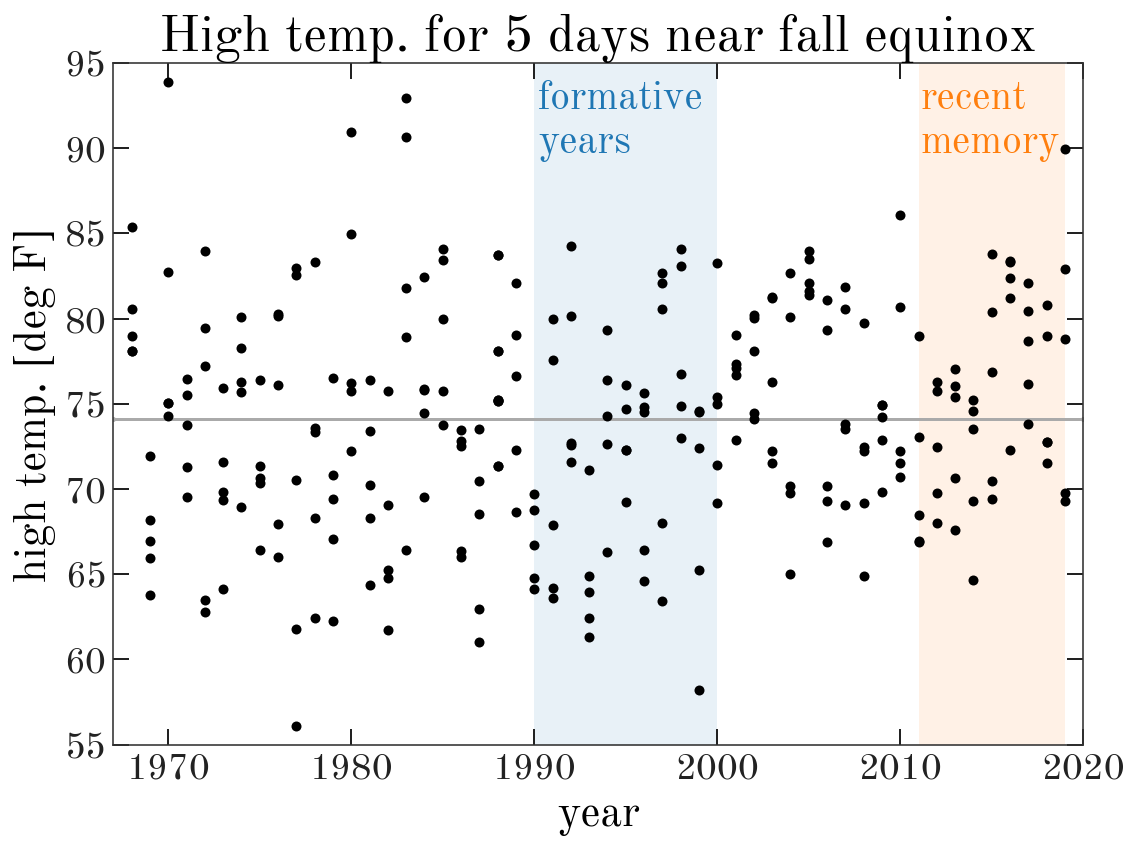

In [175]:
g = df[(df.month == 9) & 
       (df.day > (today.day - 5)) & 
       (df.day <= today.day)]

# Plot:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.plot(g['year'], g['temperatureHigh'], 
        marker='o', ls='none')

ax.axvspan(1990, 2000, 
           alpha=0.1, zorder=-100, 
           color='tab:blue', lw=0)
ax.text(1990+0.2, 94, 'formative\nyears', 
        fontsize=20, va='top', zorder=100,
        color='tab:blue')

ax.axvspan(2011, 2019, 
           alpha=0.1, zorder=-100, 
           color='tab:orange', lw=0)
ax.text(2011+0.1, 94, 'recent\nmemory', 
        fontsize=20, va='top', zorder=100, 
        color='tab:orange')

ax.set_xlim(1967, 2020)
ax.set_ylim(55, 95)

ax.set_xlabel('year')
ax.set_ylabel('high temp. [deg F]')

ax.set_title('High temp. for 5 days near fall equinox')

ax.axhline(g['temperatureHigh'].mean(), zorder=-100, color='#aaaaaa')

fig.tight_layout()

In the above plot, black points are the high temperature values for 5 days near the fall equinox for years in my chosen date range. I've highlighted my "formative years," when I would have had noticed the weather as a kid, and I've also highlighted the last few years as "recent memory." The horizontal line shows the mean high temperature over the whole date range. Today (2019-09-23) stands out as the balmy 90 degree day on the far right of the plot.

Visually, it does seem that high temperatures were more or less scattered around the mean during my youth, whereas the last few years seem to have been quite warm. But the variance is pretty large in any year. Still, the lower envelope of the high temperatures does seem to be moving up in recent years.

In [180]:
this_year = df[df['year'] == 2019]

In [185]:
col = df.groupby(['month', 'day'])['temperatureHigh'].describe(percentiles=[0.05, 0.95])

In [ ]:
smooth = 2.5
start_m = 1

date_x = []
magic_year = 2024
for m, d in col.index:
    date_x.append(datetime.date(magic_year, m, d))
date_x = np.array(date_x, dtype=np.datetime64)

this_x = np.array([datetime(hack_year, m, d) if m >= start_m else datetime(hack_year+1, m, d)
                   for m, d in zip(this_year['month'], this_year['day'])], 
                  dtype=np.datetime64)

fig, axes = plt.subplots(2, 1, figsize=(10, 10),
                         sharey=True)

for ax, name, color in zip(axes, ['High', 'Low'], ['tab:red', 'tab:blue']):
    colname = 'apparentTemperature{0}'.format(name)
    
    ax.plot(x[x.argsort()], 
            gaussian_filter1d(g.mean()[colname][x.argsort()], smooth), 
            color=color, marker='', alpha=0.8, linestyle='--', zorder=100)
    
    percentiles = np.full((len(g), 2), np.nan)
    for i, (_, row) in enumerate(g):
        percentiles[i] = np.percentile(row[colname], [16, 84])

    ax.fill_between(x[x.argsort()], 
                    gaussian_filter1d(percentiles[:, 0][x.argsort()], smooth), 
                    gaussian_filter1d(percentiles[:, 1][x.argsort()], smooth),
                    zorder=100, color=color, linewidth=0, alpha=0.25)
    
    # --
    percentiles = np.full((len(g), 2), np.nan)
    for i, (_, row) in enumerate(g):
        percentiles[i] = np.percentile(row[colname], [1, 99])

    ax.fill_between(x[x.argsort()], 
                    gaussian_filter1d(percentiles[:, 0][x.argsort()], smooth), 
                    gaussian_filter1d(percentiles[:, 1][x.argsort()], smooth),
                    zorder=100, color=color, linewidth=0, alpha=0.1)

    ax.plot(this_x[this_x.argsort()], 
            this_year.iloc[this_x.argsort()][colname],
            color=color, lw=2, linestyle='-', marker='',
            zorder=101)

    ax.set_xlim(datetime(hack_year, start_m, 1), 
                datetime(hack_year, 12, 31))
    ax.set_ylim(-12, 102)
    ax.yaxis.set_ticks(np.arange(-10, 100+1, 10))
    ax.grid(zorder=-10, color='#eeeeee')
    
    ax_c = ax.twinx()
    ax_c.set_ylim((ax.get_ylim()*u.imperial.Fahrenheit).to(u.Celsius, u.temperature()).value)

    ax.set_ylabel(r'temperature [$^\circ {\rm F}$]')
    ax_c.set_ylabel(r'temperature [$^\circ {\rm C}$]')
    
    ax.set_axisbelow(False)

    xticks = [datetime(hack_year, x, y) 
              for x in range(start_m, 12+1) for y in [1, 15]]
    #xticks = xticks + [datetime(hack_year+1, x, y) 
    #                   for x in range(1, 3+1) for y in [1, 15]]
    ax.xaxis.set_ticks(xticks)

    myFmt = DateFormatter("%m-%d")
    ax.xaxis.set_major_formatter(myFmt)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

axes[0].text(datetime(hack_year, start_m, 15), 0, 
             'High temperature', 
             fontsize=22, ha='left', va='bottom')
    
fig.tight_layout()
fig.set_facecolor('w')

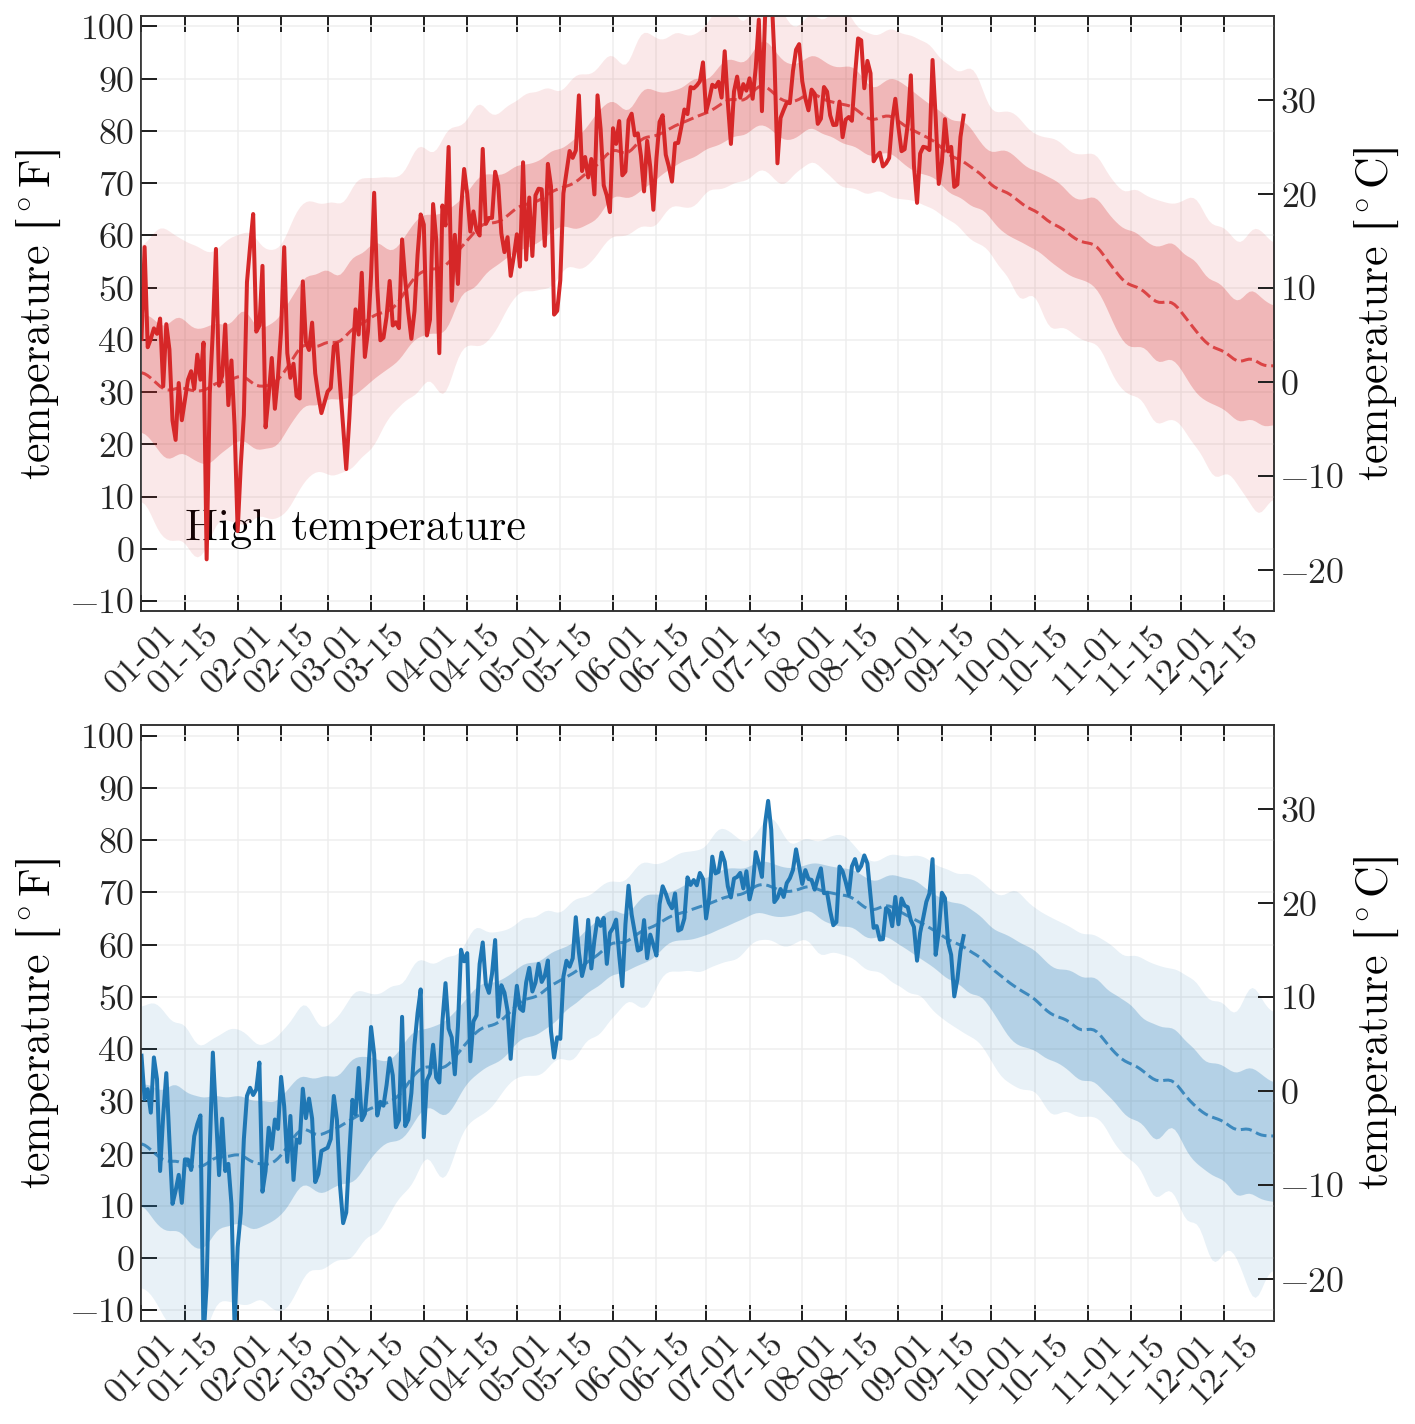

In [139]:
smooth = 2.5
start_m = 1
hack_year = 2024
x = np.array([datetime(hack_year, m, d) if m >= start_m else datetime(hack_year+1, m, d)
              for m, d in g.groups.keys()], 
             dtype=np.datetime64)

this_x = np.array([datetime(hack_year, m, d) if m >= start_m else datetime(hack_year+1, m, d)
                   for m, d in zip(this_year['month'], this_year['day'])], 
                  dtype=np.datetime64)

fig, axes = plt.subplots(2, 1, figsize=(10, 10),
                         sharey=True)

for ax, name, color in zip(axes, ['High', 'Low'], ['tab:red', 'tab:blue']):
    colname = 'apparentTemperature{0}'.format(name)
    
    ax.plot(x[x.argsort()], 
            gaussian_filter1d(g.mean()[colname][x.argsort()], smooth), 
            color=color, marker='', alpha=0.8, linestyle='--', zorder=100)
    
    percentiles = np.full((len(g), 2), np.nan)
    for i, (_, row) in enumerate(g):
        percentiles[i] = np.percentile(row[colname], [16, 84])

    ax.fill_between(x[x.argsort()], 
                    gaussian_filter1d(percentiles[:, 0][x.argsort()], smooth), 
                    gaussian_filter1d(percentiles[:, 1][x.argsort()], smooth),
                    zorder=100, color=color, linewidth=0, alpha=0.25)
    
    # --
    percentiles = np.full((len(g), 2), np.nan)
    for i, (_, row) in enumerate(g):
        percentiles[i] = np.percentile(row[colname], [1, 99])

    ax.fill_between(x[x.argsort()], 
                    gaussian_filter1d(percentiles[:, 0][x.argsort()], smooth), 
                    gaussian_filter1d(percentiles[:, 1][x.argsort()], smooth),
                    zorder=100, color=color, linewidth=0, alpha=0.1)

    ax.plot(this_x[this_x.argsort()], 
            this_year.iloc[this_x.argsort()][colname],
            color=color, lw=2, linestyle='-', marker='',
            zorder=101)

    ax.set_xlim(datetime(hack_year, start_m, 1), 
                datetime(hack_year, 12, 31))
    ax.set_ylim(-12, 102)
    ax.yaxis.set_ticks(np.arange(-10, 100+1, 10))
    ax.grid(zorder=-10, color='#eeeeee')
    
    ax_c = ax.twinx()
    ax_c.set_ylim((ax.get_ylim()*u.imperial.Fahrenheit).to(u.Celsius, u.temperature()).value)

    ax.set_ylabel(r'temperature [$^\circ {\rm F}$]')
    ax_c.set_ylabel(r'temperature [$^\circ {\rm C}$]')
    
    ax.set_axisbelow(False)

    xticks = [datetime(hack_year, x, y) 
              for x in range(start_m, 12+1) for y in [1, 15]]
    #xticks = xticks + [datetime(hack_year+1, x, y) 
    #                   for x in range(1, 3+1) for y in [1, 15]]
    ax.xaxis.set_ticks(xticks)

    myFmt = DateFormatter("%m-%d")
    ax.xaxis.set_major_formatter(myFmt)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

axes[0].text(datetime(hack_year, start_m, 15), 0, 
             'High temperature', 
             fontsize=22, ha='left', va='bottom')
    
fig.tight_layout()
fig.set_facecolor('w')

In [10]:
month_names = dict()
month_names[1] = 'Jan'
month_names[2] = 'Feb'
month_names[3] = 'Mar'
month_names[4] = 'Apr'
month_names[5] = 'May'
month_names[6] = 'Jun'
month_names[7] = 'Jul'
month_names[8] = 'Aug'
month_names[9] = 'Sep'
month_names[10] = 'Oct'
month_names[11] = 'Nov'
month_names[12] = 'Dec'

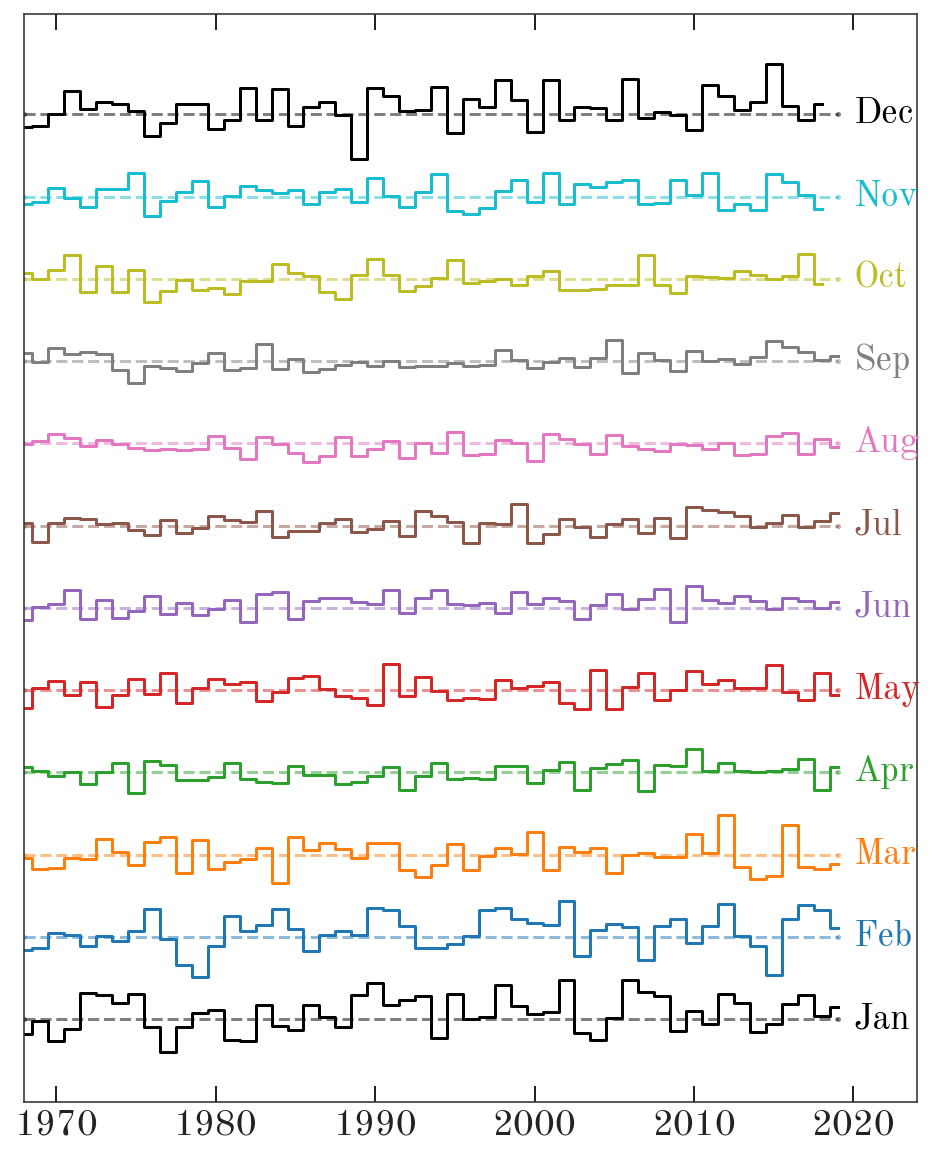

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(8, 10))

slopes = []
for i in range(1, 12+1):
    sub = df[df['month'] == i]
    sub = sub.groupby('year').mean()
    
    years = sub['temperatureHigh'].index.values
    temps = sub['temperatureHigh'].values
    
    coeff = np.polyfit(years, temps, deg=1)
    slopes.append(coeff[0])
    
    zp = np.mean(temps[:10])
    l, = ax.plot(years, temps - zp + 20*i,
                 drawstyle='steps-mid', marker='')
    ax.plot([1968, 2019], [20*i, 20*i], 
            color=l.get_color(), zorder=-100, 
            alpha=0.5, linestyle='--')
    ax.text(2020, 20*i, month_names[i], color=l.get_color(),
            fontsize=18, ha='left', va='center')
    
ax.set_xlim(1968, 2024)
ax.yaxis.set_visible(False)

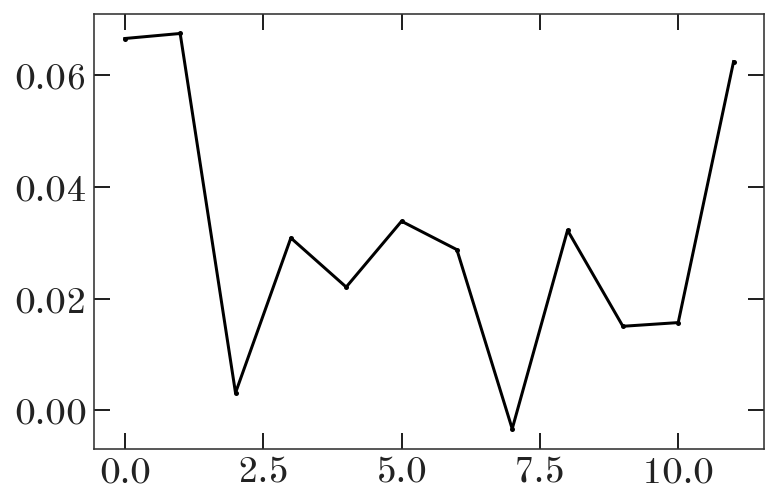

In [32]:
plt.plot(slopes)

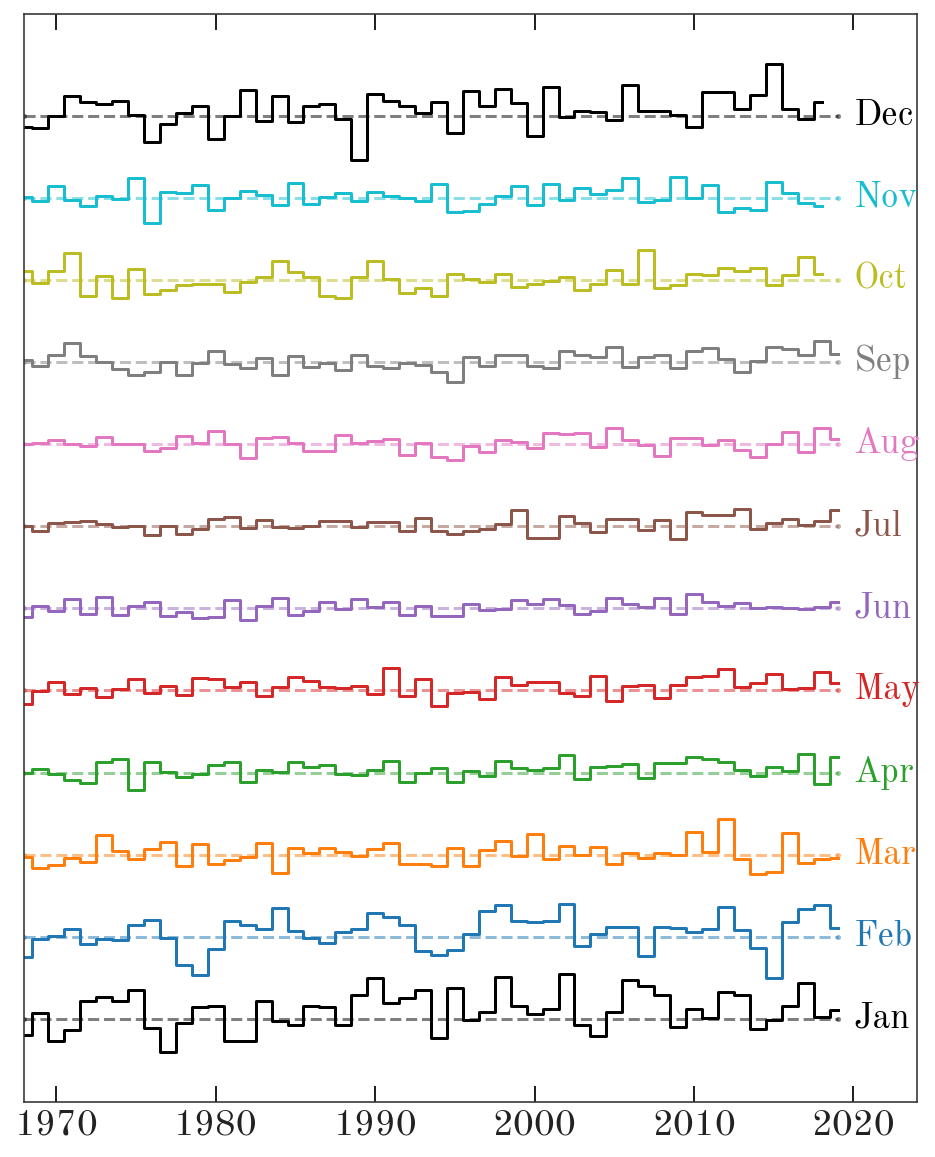

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(8, 10))

slopes = []
for i in range(1, 12+1):
    sub = df[df['month'] == i]
    sub = sub.groupby('year').mean()
    
    years = sub['temperatureLow'].index.values
    temps = sub['temperatureLow'].values
    
    coeff = np.polyfit(years, temps, deg=1)
    slopes.append(coeff[0])
    
    zp = np.mean(temps[:10])
    l, = ax.plot(years, temps - zp + 20*i,
                 drawstyle='steps-mid', marker='')
    ax.plot([1968, 2019], [20*i, 20*i], 
            color=l.get_color(), zorder=-100, 
            alpha=0.5, linestyle='--')
    ax.text(2020, 20*i, month_names[i], color=l.get_color(),
            fontsize=18, ha='left', va='center')
    
ax.set_xlim(1968, 2024)
ax.yaxis.set_visible(False)

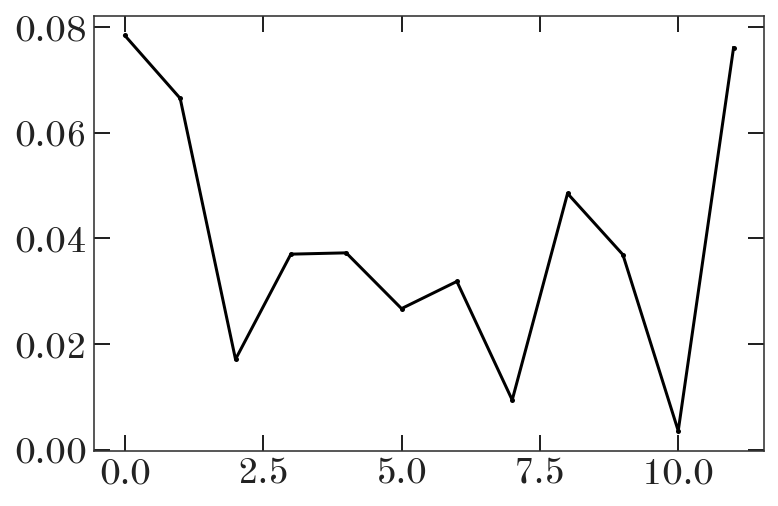

In [34]:
plt.plot(slopes)